# Implementing Vision Transformer from Scratch

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from keras import layers
from keras.datasets import cifar100
import tensorflow_addons as tfa

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import warnings
warnings.filterwarnings('ignore')

e:\Programming\Python_Venvs\venv_02\venv_02\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


# Hyperparameters

In [ ]:
BATCH_SIZE = 64
EPOCH = 2
PATCH_SIZE = 4  # -> number of patches=8  or sequence_length is 8 since images are 32*32
NUM_PATCH = 64 # (32*32*3) / (8*8*1) = 4*4*3
MODEL_DIM = 32  # (4*4*3) = 48 is the main dimension
NUM_LAYERS = 2
NUM_HEAD = 4


# Data

### Load data

In [3]:
(X_train, y_train), (X_test, y_test) = cifar100.load_data()

print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_test shape: {y_test.shape}')

X_train shape: (50000, 32, 32, 3)
y_train shape: (50000, 1)
X_test shape: (10000, 32, 32, 3)
y_test shape: (10000, 1)


### Extract Patches

In [4]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size


    def call(self, images):
        patches = tf.image.extract_patches(
            images = images,
            sizes = [1, self.patch_size, self.patch_size, 1],
            strides = [1, self.patch_size, self.patch_size, 1],
            rates = [1, 1, 1, 1],
            padding = "VALID",
        )

        out = tf.reshape(patches, [tf.shape(images)[0], -1, patches.shape[-1]])
        return out

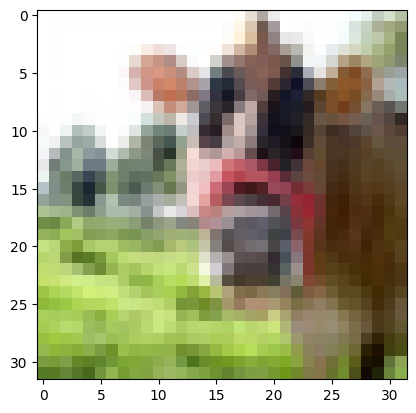

In [5]:
plt.imshow(X_train[0])

# make sure to add [] to the image to add batch dimension
patches = Patches(PATCH_SIZE)([X_train[0]]) # 8 patches row * 8 patches column -> 64 patches
# each patch is 4*4 and since we have 3 channels -> 4*4*3 = 48 sequence length

# print(patches)

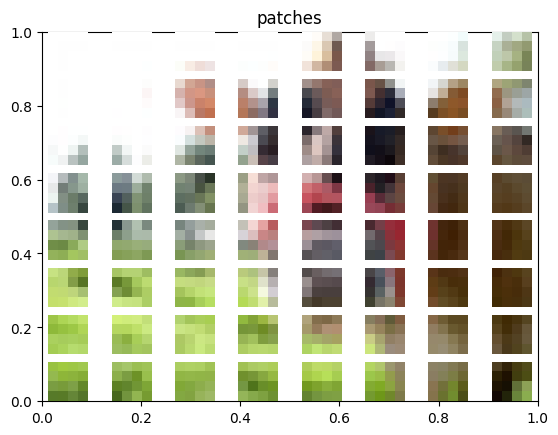

In [6]:
n = int(np.sqrt(patches.shape[1]))
plt.figure()
plt.title('patches')
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i+1)
    img = np.array(tf.reshape(patch, [4,4,3])).astype('uint8')
    plt.imshow(img)
    plt.axis('off')

In [15]:
class PatchEncoder(layers.Layer):
    def __init__(self, patch_number, model_dim):
        super().__init__()
        self.num_patch = patch_number
        self.linear_projection = layers.Dense(model_dim)
        self.positional_embedding = layers.Embedding(patch_number, model_dim)


    def call(self, patch):
        out = self.linear_projection(patch)
        out = out + self.positional_embedding(tf.range(start=0, limit=self.num_patch, delta=1))
        return out


In [16]:
patches

<tf.Tensor: shape=(1, 64, 48), dtype=uint8, numpy=
array([[[255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 253, 255, 255],
        [255, 255, 255, ..., 238, 227, 227],
        ...,
        [179, 213,  97, ..., 126, 122,  74],
        [140, 130, 101, ...,  76,  78,  24],
        [ 77,  62,  33, ..., 138, 173,  79]]], dtype=uint8)>

In [17]:
encoded_patches = PatchEncoder(NUM_PATCH, MODEL_DIM)(patches)

In [ ]:
class MLP(layers.Layer):
    def __init__(self):
        super().__init__(self)
        self.mlp = layers.Dense()

    def call(self, x):
        return self.mlp(x)

In [ ]:
for i in range(NUM_LAYERS):
    x1 = layers.LayerNormalization()(encoded_patches)
    mha = layers.MultiHeadAttention(NUM_HEAD, MODEL_DIM, MODEL_DIM, dropout=0.1)(x1, x1)
    x1 = x1 + mha
    x2 = layers.LayerNormalization()(x1)
    